In [1]:
%matplotlib inline
import numpy as np
import random
import itertools
import os
import glob
import math
import time
import multiprocessing as mp
print('CPU:', mp.cpu_count())

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.collections import PatchCollection
import matplotlib.colors as colors
plt.style.use('classic')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('figure', facecolor='w')
rc('ytick', labelsize=25)
rc('xtick', labelsize=25)

from ipywidgets import interactive
import ipywidgets as widgets

CPU: 4


### Question 1a: Simulation Explaination

Simulation parameters:
- `E` : initial energy of each particle, set to be equal for t=0
- `N` : number of particles
- `s` : particle radius  
- `L` : box length
- `T` : number of time steps
- `dt` : time step
- `x` : x coordinate position (`x0` is the initial position)
- `y` : y coordinate position (`y0` is the initial position)
- `v` : x coordinate velocity (`v0` is the initial velocity)
- `u` : y coordinate velocity (`u0` is the initial velocity)

Simulation steps:
1. Particle positions are initialized by the function `initializePositions(L, N, s)`.
    - this function generates N particles with radius s within an LxL dimension box. x and y positions are drawn from a uniform distribution $x,y \sim U(s,L-s)$. To ensure that no particles are overlaping, a while loop is used to check that no proposed particle position falls within 2s distance of other particles.
    

2. Particle positions are initialized by the function `initializeVelocities(E, m, N)`
    - this function generates random velocities for N particles with equal initial energies E, and with different masses given by the vector m. First the total velocities of each particle are computed, where $ v_{tot} = \sqrt{2E/m} $. Next the x and y velocity components (v and u) are computed where a random angle phi is chosen $\phi \sim U(0,2\pi)$ and $v = v_{tot} \cos\phi$, $u = v_{tot} \sin\phi$.
    
    
3. Particle positions/velocities for different timesteps are computed with the function `runSimulation(x0, y0, v0, u0, m, T, s, L)`
    - this function computes the 2D positions and velocities for T timesteps given initial conditions x0, y0, v0, u0. 
    - in the first step each particle (i=0,...,N) positions are advanced for the next timestep, where
    $$ x_i' = x_i + v_i * dt $$
    $$ y_i' = y_i + u_i * dt $$
    - next the code checks for wall collisions: if the $x,y<s$ or $x,y>L-s$, then the velocities are reversed so the particle will bounce off the wall. 
    - next the code checks for particle-particle collisions. The line of code `itertools.combinations(range(N), 2)` gives all N choose 2 possible combinations of 2 particles to check collisions for. If the distance between two given particles is less than 2s, then it concludes a collision has occurred.
    - imposing the assumption that particles must conserve energy and momentum after each collision in 2D, we get the following equations for initial and final velocities for a collision between two particles i and j (https://en.wikipedia.org/wiki/Elastic_collision):
    $$ v_i' = v_i - \frac{2m_j}{m_i + m_j} \frac{\langle v_i-v_j, x_i-x_j \rangle}{\|x_i-x_j\|^2} (x_i-x_j) $$ 
    $$ v_j' = v_j - \frac{2m_i}{m_i + m_j} \frac{\langle v_j-v_i, x_j-x_i \rangle}{\|x_j-x_i\|^2} (x_j-x_i) $$ 
    
Important note: this implementation of the code assumes that only one collision per timestep occurs, therefore it is important to choose a small enough timestep to not introduce errors. As seen in the code below, my choice of parameter values are:
```
E = 1     # energy
N = 100   # number of particles
s = 2     # particle radius  
L = 100   # box length
T = 10**5   # number of time steps
dt = .001   # time step
```

### Question 1b: Plots of Results

![](ideal_gas_sim1.gif) 

### Question 2c: Simulation with half masses 10x larger

![](ideal_gas_sim2.gif)

### Simulation Code

In [60]:
def dist(v1, v2):
    
    return np.sqrt((v2[0] - v1[0])**2 + (v2[1] - v1[1])**2)


def initializePositions(L, N, s):
    """
    Generate a N particles with radius s 
    in box size L that do not overlap
    """
    
    x0, y0 = [], []
    x0.append(np.random.uniform(s,L-s))
    y0.append(np.random.uniform(s,L-s))

    for i in range(1,N):

        K = len(x0)
        collision = [True for i in range(K)]

        while True in collision:
            xi_prop = np.random.uniform(s,L-s)
            yi_prop = np.random.uniform(s,L-s)

            for k in range(K):

                d = dist((x0[k], y0[k]), (xi_prop, yi_prop))
                if d < 2*s:
                    collision[k] = True
                else:
                    collision[k] = False

        x0.append(xi_prop)
        y0.append(yi_prop)
        
    return np.array(x0), np.array(y0)


def initializeVelocities(E, m, N):
    
    vtot = np.sqrt(2*E/m) * np.ones(N)
    phi = np.random.uniform(0,2*math.pi,N)
    
    u0 = vtot * np.cos(phi)
    v0 = vtot * np.sin(phi)
    
    return v0, u0

In [45]:
def runSimulation(x0, y0, v0, u0, m, T, s, L):
    
    N = len(x0)
    pos_x, pos_y = [x0], [y0]
    vel_x, vel_y = [v0], [u0]

    for t in range(T): #iterate over time-step
        
        x_curr, y_curr = pos_x[-1], pos_y[-1]
        v_curr, u_curr = vel_x[-1], vel_y[-1]
        
        x_new, y_new = np.zeros(N), np.zeros(N)
        v_new, u_new = np.zeros(N), np.zeros(N)

        # ================================
        # Advance particle positions
        # ================================
        for i in range(N): #iterate over each particle
    
            xprop_i = x_curr[i] + v_curr[i] * dt
            yprop_i = y_curr[i] + u_curr[i] * dt    
           
            # ================================
            # Check for particle-wall collisions
            # ================================
            if xprop_i < s:   # left wall
                v_new[i] = -v_curr[i]

            elif xprop_i > L-s:   # right wall
                v_new[i] = -v_curr[i]

            else:
                v_new[i] = v_curr[i]

            if yprop_i < s:   # bottom wall
                u_new[i] = -u_curr[i]

            elif yprop_i > L-s:   # top wall
                u_new[i] = -u_curr[i]

            else:
                u_new[i] = u_curr[i]
                
            x_new[i] = xprop_i
            y_new[i] = yprop_i

            
        # ================================
        # Check for particle-particle collisions
        # ================================
        
        # Iterate over all (N choose 2) combinations of particle pairs
        perm = list(itertools.combinations(range(N), 2))
        
        for p in perm:
            
            i, j = p
            separation = np.sqrt((x_new[i] - x_new[j])**2 + (y_new[i] - y_new[j])**2)
            
            if separation < 2*s:
                
                ri_curr = np.array([x_new[i], y_new[i]])
                rj_curr = np.array([x_new[j], y_new[j]])
            
                si_curr = np.array([v_curr[i], u_curr[i]])
                sj_curr = np.array([v_curr[j], u_curr[j]])
            
                si_new = si_curr - (2*m[j])/(m[i] + m[j]) * np.dot(si_curr-sj_curr, ri_curr-rj_curr) \
                                    / np.linalg.norm(ri_curr - rj_curr)**2 * (ri_curr - rj_curr)
                
                sj_new = sj_curr - (2*m[i])/(m[i] + m[j]) * np.dot(sj_curr-si_curr, rj_curr-ri_curr) \
                                    / np.linalg.norm(rj_curr - ri_curr)**2 * (rj_curr - ri_curr)
                
                v_new[i], u_new[i] = si_new
                v_new[j], u_new[j] = sj_new
        
        pos_x.append(x_new)
        pos_y.append(y_new) 

        vel_x.append(v_new)
        vel_y.append(u_new)  
        
    return np.array(pos_x), np.array(pos_y), np.array(vel_x), np.array(vel_y)

In [4]:
def plotParticles(x, y, **kwargs):    

    fig, ax = plt.subplots(figsize=[10,10])
    
    circles = []
    for i in range(N):
        if 'm' in kwargs:
            circle = plt.Circle((x[i], y[i]), radius=s)
            circles.append(circle)
        else:
            circle = plt.Circle((x[i], y[i]), radius=s, color='r')
            ax.add_artist(circle)
        
    if 'm' in kwargs:
        m = kwargs.get('m')
        crng = kwargs.get('crng', [.01,10])
        p = PatchCollection(circles, cmap='Blues', edgecolor='none', \
                            norm=colors.LogNorm(vmin=crng[0], vmax=crng[1]))
        p.set_array(m)
        ax.add_collection(p)
        fig.colorbar(p, ax=ax, fraction=0.046, pad=0.04)
        
    if ('v' in kwargs) and ('u' in kwargs):
        v = kwargs.get('v')
        u = kwargs.get('u')
        for i in range(N):
            ax.arrow(x[i], y[i], v[i], u[i], head_width=.8, head_length=1, fc='k', ec='k')

    ax.set_aspect('equal', 'box')
    plt.xlim(0,L)
    plt.ylim(0,L)
    if 't' in kwargs:
        plt.title(r"$T=%s$"%(kwargs.get('t')), fontsize=30)
    plt.minorticks_on()
    if 'save' in kwargs:
        plt.savefig(kwargs.get('save'))
    plt.close()
    
    return fig

## Run Simulation

In [63]:
E = 1     # energy
N = 100   # number of particles
s = 2     # particle radius  
L = 100   # box length
T = 10**5   # number of time steps
dt = .001   # time step

# m = np.ones(N)
m = np.concatenate(([1 for i in range(50)], [10 for i in range(50)]))

x0, y0 = initializePositions(L, N, s)
v0, u0 = initializeVelocities(E, m, N)

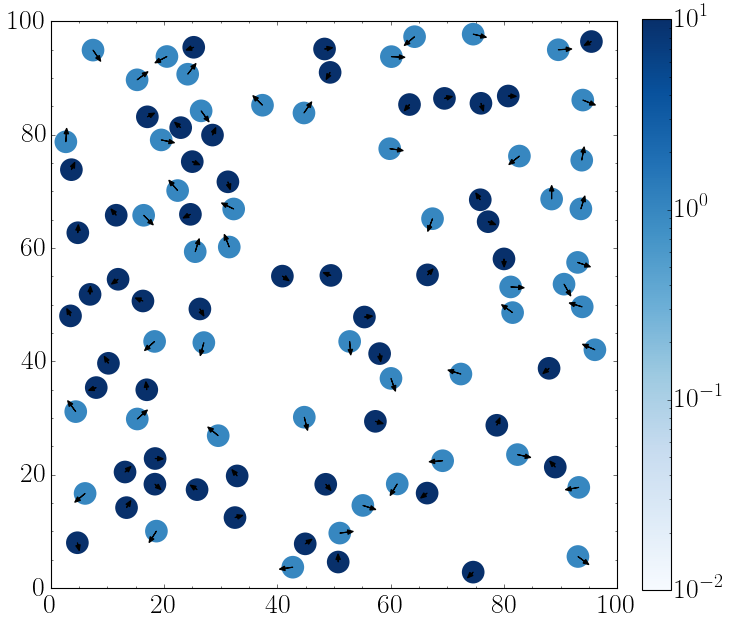

In [64]:
plotParticles(x0, y0, v=v0, u=u0, m=m, crng=[.01,10])

In [66]:
t0 = time.time()
pos_x, pos_y, vel_x, vel_y = runSimulation(x0, y0, v0, u0, m, T, s, L)
print(time.time() - t0)
print((time.time() - t0)/60)

2201.1312232017517
36.68552320798238


In [67]:
sdir = 'results/'

np.save(sdir + 'pos_x', pos_x)
np.save(sdir + 'pos_y', pos_y)
np.save(sdir + 'vel_x', vel_x)
np.save(sdir + 'vel_y', vel_y)

pos_x = np.load(sdir + 'pos_x.npy')
pos_y = np.load(sdir + 'pos_y.npy')
vel_x = np.load(sdir + 'vel_x.npy')
vel_y = np.load(sdir + 'vel_y.npy')

### Plot and Animate

In [68]:
for f in glob.glob('plots/*'):
    os.system(f'rm {f}')

def plotSeries(t):
    # pl = plotParticles(pos_x[t], pos_y[t], t=t, save=f'plots/t{t}.png')
    pl = plotParticles(pos_x[t], pos_y[t], v=vel_x[t], u=vel_y[t], m=m, crng=[.01,10], t=t, save=f'plots/t{t}.png')
    
tvals = np.arange(0,T,200)
print(f'Generating {len(tvals)} plots...')
pool = mp.Pool(mp.cpu_count())  

t0 = time.time()
result = pool.map(plotSeries, tvals)
print(time.time() - t0)
print((time.time() - t0)/60)

Generating 500 plots...
155.87166047096252
2.597864619890849


In [53]:
ordered_plots = ' '.join([f'plots/t{i}.png' for i in tvals])
os.system(f'convert -delay 0 -loop 10 {ordered_plots} animation.gif')

0

In [324]:
def plot_interact(t=0):    
    
    return plotParticles(pos_x[t], pos_y[t], u=vel_x[t], v=vel_y[t])

interactive_plot = interactive(plot_interact, t=(0,T,50))
output = interactive_plot.children[-1]
output.layout.height = '700px'
interactive_plot

interactive(children=(IntSlider(value=0, description='t', max=1000, step=50), Output(layout=Layout(height='700…